<h1 style="text-align: center;"><b>IMDB Sentiment Analysis using GRU, LSTM and LSTM Bidirectional </b></h1>

**Pair:**
* [*BOUSSELAT Ahmed Moncef*](https://github.com/Somnef)
* [*KIMOUCHE Rayane*](https://github.com/RayaneKimo)

## **Introduction**

**Sentiment Analysis** is the process of computationally identifying and categorizing opinions expressed in a piece of text, especially in order to determine whether the writer's attitude towards a particular topic, product, etc. is positive, negative, or neutral.

So, here we have as a topic the IMDB movie dataset that contains different opinions related to movies. And we will build classifiers on those datas using 3 Deep Learning techniques called **Recurrent Neural Network (RNN)**, and two variations of the **Long-short term memory (LSTM)**


In [ ]:
import os
import re
import shutil
import string

Download dataset:

In [2]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84125825/84125825 [==============================] - 6s 0us/step


In [4]:
dataset_dir

'./aclImdb'

Explore directories:

In [5]:
os.listdir(dataset_dir)

['imdbEr.txt', 'train', 'README', 'test', 'imdb.vocab']

In [6]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['urls_unsup.txt',
 'urls_pos.txt',
 'labeledBow.feat',
 'unsup',
 'pos',
 'urls_neg.txt',
 'neg',
 'unsupBow.feat']

In [7]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())


Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


##Load data from directories using text_dataset_from_directory



In [8]:
# remove the "unsup" folder to respect the folder structure
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [9]:
ff = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    seed=42)

Found 25000 files belonging to 2 classes.


In [10]:
# Create validation and training sets from the training folder
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset="training", 
    seed=seed)

raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset="validation", 
    seed=seed)


Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [11]:
# create test dataset 
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


In [12]:
raw_train_ds.class_names

['neg', 'pos']

In [13]:
raw_train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [14]:
# show one batch of reviews
for i in raw_train_ds.take(1):
  print(i[0])

tf.Tensor(
[b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
 b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into complicat

In [15]:
# show one batch of corresponding labels
for i in raw_train_ds.take(1):
  print(i[1])

tf.Tensor([1 1 1 1 1 1 0 0 0 0 1 1 0 1 0 0 1 0 0 1 0 0 0 1 0 1 0 1 1 1 0 0], shape=(32,), dtype=int32)


In [16]:
for text, label in raw_test_ds.take(1):
  for i in range(1):
    print(text[i])
    print(label[i])

tf.Tensor(b"This is truly one of the worst films I have ever seen in my life. Rod Steiger who stars as the ornery grandfather, Charlie, is in full overacting mode hoping that the more flashy he is, the better his performance (Cue buzzer sound). Rod Steiger is one of the last true film legends and to see him in this film (although End of Days is the 2nd worst film I've ever seen) is really heartbreaking. From the bad storyline to the nonexistent direction, it becomes abudantly clear that the only reason this film was made was that the producer's last name ended in DeLaurentis. The only good thing about this film is that it is so bad, it's truly hysterical. Look for the flashback scene where Rod where's a Jor-El wig from Superman and a big black porno mustache. One only hopes that his follow up film, I Believe in America, from Uber-producer Kevin Arbouet will redeem him and leave a good taste in everyone's mouths.", shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int32)


##Text pre-processing




In [17]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

Create the pre-processing layer:

In [18]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

Fit the pre-processing layer (vectorize_layer) to the training data


In [19]:
# remove labels 
train_text = raw_train_ds.map(lambda x, y: x)

# fit the layer using the adapt method
vectorize_layer.adapt(train_text)

See result of the pre-processing layer:

In [20]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [ ]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))

first_review, first_label = text_batch[0], label_batch[0]

print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])

print("Vectorized review", vectorize_text(first_review, first_label))

In [22]:
print("48 ---> ",vectorize_layer.get_vocabulary()[48])

print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

48 --->  what
Vocabulary size: 10000


In [23]:
vectorize_layer.get_vocabulary()[:10]

['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it']

Apply the pre-processing layer all the sets:

In [24]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

Pipeline optimization:

In [25]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Recurrent Neural Network (Gated recurrent unit)
---



## Import all libraries

In [138]:
import tensorflow as tf
from tensorflow.keras import losses
from tensorflow.keras.layers import LSTM, Dense, Embedding, GRU, SimpleRNN,Bidirectional, Dropout, SpatialDropout1D
from tensorflow.keras.preprocessing.sequence import  pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.models import Sequential

## Architecture

In [122]:
RNN = Sequential()
RNN.add(Embedding(max_features + 1, 50,input_length=sequence_length))
RNN.add(tf.keras.layers.SpatialDropout1D(0.4))
RNN.add(GRU(32, dropout=0.05, recurrent_dropout=0.2))
RNN.add(Dense(1, activation='sigmoid'))
RNN.compile(loss=losses.BinaryCrossentropy(),
              optimizer='adam',
              metrics=["acc"])
print(RNN.summary())

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_37 (Embedding)    (None, 250, 50)           500050    
                                                                 
 spatial_dropout1d_9 (Spatia  (None, 250, 50)          0         
 lDropout1D)                                                     
                                                                 
 gru_23 (GRU)                (None, 32)                8064      
                                                                 
 dense_31 (Dense)            (None, 1)                 33        
                                                                 
Total params: 508,147
Trainable params: 508,147
Non-trainable params: 0
_________________________________________________________________
None


## Model Training

In [123]:
# import datetime
stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='auto', patience=2)
# log_dir = "logs/LSTM_bidirectional/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
RNN_trained = RNN.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=[stop_callback])

Epoch 1/10
625/625 [==============================] - 234s 300ms/step - loss: 0.6924 - acc: 0.5161 - val_loss: 0.6919 - val_acc: 0.5128
Epoch 2/10
625/625 [==============================] - 178s 285ms/step - loss: 0.6663 - acc: 0.5644 - val_loss: 0.6658 - val_acc: 0.6080
Epoch 3/10
625/625 [==============================] - 174s 278ms/step - loss: 0.5987 - acc: 0.6883 - val_loss: 0.6255 - val_acc: 0.6738
Epoch 4/10
625/625 [==============================] - 173s 276ms/step - loss: 0.5386 - acc: 0.7466 - val_loss: 0.5687 - val_acc: 0.7406
Epoch 5/10
625/625 [==============================] - 174s 278ms/step - loss: 0.4915 - acc: 0.7773 - val_loss: 0.4921 - val_acc: 0.7880
Epoch 6/10
625/625 [==============================] - 175s 280ms/step - loss: 0.5535 - acc: 0.6938 - val_loss: 0.5333 - val_acc: 0.7500
Epoch 7/10
625/625 [==============================] - 200s 321ms/step - loss: 0.4266 - acc: 0.8285 - val_loss: 0.4783 - val_acc: 0.8010
Epoch 8/10
625/625 [============================

## Performance Visualisation

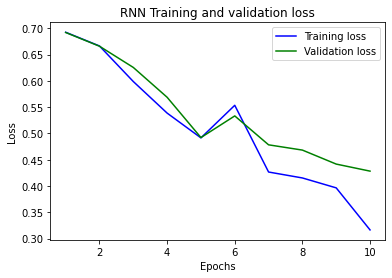

In [151]:
import matplotlib.pyplot as plt
history_RNN = RNN_trained.history

acc = history_RNN['acc']
val_acc = history_RNN['val_acc']
loss = history_RNN['loss']
val_loss = history_RNN['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('RNN Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# LSTM Bidirectionnel
---


## Architecture

In [106]:
LSTM_bidirectional = Sequential()
LSTM_bidirectional.add(Embedding(max_features + 1, 32,input_length=sequence_length))
LSTM_bidirectional.add(tf.keras.layers.SpatialDropout1D(0.4))
LSTM_bidirectional.add(Bidirectional(LSTM(32, dropout=0.05, recurrent_dropout=0.2)))
LSTM_bidirectional.add(Dense(1, activation='sigmoid'))
LSTM_bidirectional.compile(loss=losses.BinaryCrossentropy(),
              optimizer='adam',
              metrics=["acc"])
print(LSTM_bidirectional.summary())

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_32 (Embedding)    (None, 250, 32)           320032    
                                                                 
 spatial_dropout1d_4 (Spatia  (None, 250, 32)          0         
 lDropout1D)                                                     
                                                                 
 bidirectional_8 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dense_26 (Dense)            (None, 1)                 65        
                                                                 
Total params: 336,737
Trainable params: 336,737
Non-trainable params: 0
_________________________________________________________________
None


## Model Training

In [107]:
# import datetime
stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='auto', patience=2)
# log_dir = "logs/LSTM_bidirectional/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
LSTM_bidirectional_trained = LSTM_bidirectional.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=[stop_callback])

Epoch 1/10
625/625 [==============================] - 344s 525ms/step - loss: 0.5399 - acc: 0.7234 - val_loss: 0.4079 - val_acc: 0.8314
Epoch 2/10
625/625 [==============================] - 330s 528ms/step - loss: 0.3484 - acc: 0.8582 - val_loss: 0.3689 - val_acc: 0.8454
Epoch 3/10
625/625 [==============================] - 353s 565ms/step - loss: 0.2616 - acc: 0.9004 - val_loss: 0.3467 - val_acc: 0.8516
Epoch 4/10
625/625 [==============================] - 344s 550ms/step - loss: 0.2104 - acc: 0.9219 - val_loss: 0.3407 - val_acc: 0.8574
Epoch 5/10
625/625 [==============================] - 332s 531ms/step - loss: 0.1976 - acc: 0.9290 - val_loss: 0.3760 - val_acc: 0.8496
Epoch 6/10
625/625 [==============================] - 322s 515ms/step - loss: 0.1745 - acc: 0.9384 - val_loss: 0.4513 - val_acc: 0.8522


## Performance Visualisation

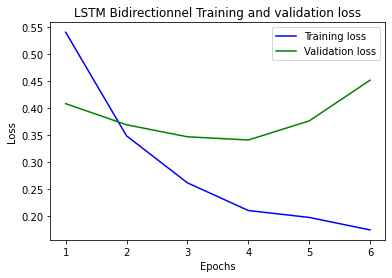

In [152]:
history_LSTM_bidirectional = LSTM_bidirectional_trained.history

acc = history_LSTM_bidirectional['acc']
val_acc = history_LSTM_bidirectional['val_acc']
loss = history_LSTM_bidirectional['loss']
val_loss = history_LSTM_bidirectional['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('LSTM Bidirectionnel Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# LSTM
---

## Architecture

In [143]:
lstm = Sequential()
lstm.add(Embedding(max_features + 1, 100 ,input_length=sequence_length))
lstm.add(tf.keras.layers.SpatialDropout1D(0.3))
lstm.add(LSTM(128,dropout=0.5))
lstm.add(Dense(1, activation='sigmoid'))
lstm.compile(loss=losses.BinaryCrossentropy(),
              optimizer='adam',
              metrics=["acc"])
print(lstm.summary())

Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_53 (Embedding)    (None, 250, 100)          1000100   
                                                                 
 spatial_dropout1d_16 (Spati  (None, 250, 100)         0         
 alDropout1D)                                                    
                                                                 
 lstm_9 (LSTM)               (None, 128)               117248    
                                                                 
 dense_34 (Dense)            (None, 1)                 129       
                                                                 
Total params: 1,117,477
Trainable params: 1,117,477
Non-trainable params: 0
_________________________________________________________________
None


## Model Training

In [144]:
stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='auto', patience=2)
# log_dir = "logs/LSTM_bidirectional/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
LSTM_trained = lstm.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=[stop_callback])

Epoch 1/10
625/625 [==============================] - 322s 511ms/step - loss: 0.6931 - acc: 0.5141 - val_loss: 0.6892 - val_acc: 0.5228
Epoch 2/10
625/625 [==============================] - 318s 509ms/step - loss: 0.6729 - acc: 0.5581 - val_loss: 0.6762 - val_acc: 0.5488
Epoch 3/10
625/625 [==============================] - 312s 499ms/step - loss: 0.6561 - acc: 0.5882 - val_loss: 0.6770 - val_acc: 0.5510
Epoch 4/10
625/625 [==============================] - 317s 507ms/step - loss: 0.6321 - acc: 0.6281 - val_loss: 0.6473 - val_acc: 0.6184
Epoch 5/10
625/625 [==============================] - 313s 501ms/step - loss: 0.4936 - acc: 0.7488 - val_loss: 0.4114 - val_acc: 0.8226
Epoch 6/10
625/625 [==============================] - 314s 503ms/step - loss: 0.3914 - acc: 0.8213 - val_loss: 0.4082 - val_acc: 0.8362
Epoch 7/10
625/625 [==============================] - 315s 504ms/step - loss: 0.3045 - acc: 0.8677 - val_loss: 0.3148 - val_acc: 0.8764
Epoch 8/10
625/625 [============================

## Performance Visualisation

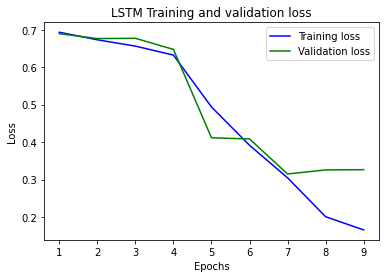

In [153]:
import matplotlib.pyplot as plt
history_dict = LSTM_trained.history

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('LSTM Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


# Evaluate the model on test data:

In [166]:
print('\033[32m            Recurrent Neural Network \033[0m')
loss, accuracy = RNN.evaluate(test_ds)
print("Loss: ", loss)
print("Accuracy: ", accuracy, end='\n')

print('\033[32m              LSTM \033[0m')
loss2, accuracy2 = LSTM_bidirectional.evaluate(test_ds)
print("Loss: ", loss2)
print("Accuracy: ", accuracy2, end='\n')

print('\033[32m             LSTM bidirectionnel \033[0m')
loss3, accuracy3 = lstm.evaluate(test_ds)
print("Loss: ", loss3)
print("Accuracy: ", accuracy3, end='\n')

print('\033[31m###################- End -###################\033[0m')



            Recurrent Neural Network 
782/782 [==============================] - 27s 35ms/step - loss: 0.4514 - acc: 0.8136
Loss:  0.45141902565956116
Accuracy:  0.8135600090026855
              LSTM 
782/782 [==============================] - 48s 61ms/step - loss: 0.5356 - acc: 0.8314
Loss:  0.5356460213661194
Accuracy:  0.8314399719238281
             LSTM bidirectionnel 
782/782 [==============================] - 108s 138ms/step - loss: 0.3748 - acc: 0.8593
Loss:  0.3748331367969513
Accuracy:  0.8593199849128723
###################- End -###################


<h3 style="text-align: center; color:#008000"><b>Le meilleur modèle avec moins de pertes et dont la meilleure précision est le LSTM Bidirectionnel </b></h3>
                                     

Inference on new data
---



Inference on new data:

In [184]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]
vectorized_exemples = vectorize_layer(examples)

LSTM_bidirectional_predict = LSTM_bidirectional.predict(vectorized_exemples, batch_size=1) 
LSTM__predict = lstm.predict(vectorized_exemples, batch_size=1) 
RNN_predict = RNN.predict(vectorized_exemples, batch_size=1) 

3/3 [==============================] - 0s 19ms/step


In [197]:
import pandas as pd

df = pd.DataFrame({"RNN":RNN_predict.ravel(), "LSTM": LSTM__predict.ravel(), "LSTM_Bidirectionnel":LSTM_bidirectional_predict.ravel()}, index=examples)
df


,RNN,LSTM,LSTM_Bidirectionnel
The movie was great!,0.907266,0.863965,0.592451
The movie was okay.,0.505271,0.182333,0.265639
The movie was terrible...,0.075340,0.096412,0.115140


<h3 style="text-align: center; color:#008000"><b>Dans ce cas, c'est le contraire que précedant. Le LSTM bidirectionnel gère mal, et le RNN (GRU) l'emporte pour les 3 prédictions</b></h3>
